In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Randomized Search CV with XGBoost

In [2]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [3]:
import utils

# preprocessed = pd.read_csv("data/preprocessed.csv")
# traindata = utils.preprocess_modeling_data(preprocessed, ohe=False, mean_imputation=True)
traindata = pd.read_csv("data/final.csv")
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14046 entries, 0 to 14045
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   surface_x                14046 non-null  float64
 1   surface_y                14046 non-null  float64
 2   gross_perforated_length  14046 non-null  float64
 3   number_of_stages         14046 non-null  float64
 4   total_proppant           14046 non-null  float64
 5   total_fluid              14046 non-null  float64
 6   true_vertical_depth      14046 non-null  float64
 7   frac_seasoning           14046 non-null  float64
 8   OilPeakRate              14046 non-null  float64
dtypes: float64(9)
memory usage: 987.7 KB


In [4]:
traindata.describe().round()

,surface_x,surface_y,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,frac_seasoning,OilPeakRate
count,14046.0,14046.0,14046.0,14046.0,14046.0,14046.0,14046.0,14046.0,14046.0
mean,1008508.0,1116650.0,6552.0,31.0,769899.0,4039800.0,8863.0,4.0,229.0
std,156608.0,323994.0,2274.0,16.0,886718.0,2606384.0,1784.0,1.0,152.0
min,584041.0,496529.0,1079.0,2.0,0.0,738.0,2430.0,0.0,0.0
25%,885624.0,816392.0,4409.0,20.0,425857.0,2075872.0,7717.0,3.0,122.0
50%,1001388.0,1182058.0,6717.0,30.0,707571.0,3585285.0,9086.0,4.0,201.0
75%,1111264.0,1396578.0,8220.0,41.0,1054714.0,5710980.0,10204.0,4.0,304.0
max,1667405.0,1794624.0,15500.0,1027.0,91090733.0,34424017.0,13145.0,8.0,2855.0


In [5]:
pd.set_option("display.max_columns", None)
traindata.sort_values(by="total_proppant",ascending=False)

,surface_x,surface_y,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,frac_seasoning,OilPeakRate
12936,9.692478e+05,1.361628e+06,5003.937008,1027.400720,9.109073e+07,2.129871e+06,9435.039370,4.077537,182.904790
9422,1.072246e+06,1.306749e+06,10931.102360,68.999099,2.496000e+06,9.278662e+06,9477.362205,4.043051,542.724149
13358,9.034680e+05,1.355616e+06,11224.409450,68.811812,2.462571e+06,1.005888e+07,9228.346457,3.891820,348.642911
13357,9.034508e+05,1.355578e+06,11223.425200,68.835499,2.456857e+06,1.018057e+07,9274.606299,3.784190,400.190538
9782,9.858701e+05,1.381853e+06,9864.173228,67.478753,2.452714e+06,1.163041e+07,9178.149606,3.912023,496.131029
...,...,...,...,...,...,...,...,...,...
2981,1.134828e+06,1.056898e+06,4351.377953,12.163271,4.690143e+03,5.209662e+04,6866.141732,4.143135,105.476207
4541,1.252864e+06,9.679122e+05,4427.165354,11.805705,3.298643e+03,5.254501e+03,4577.755906,2.833213,59.321438
3446,8.980891e+05,1.126698e+06,3347.440945,8.221092,2.169571e+03,4.720083e+04,5315.944882,2.890372,72.488106
3463,8.826111e+05,1.225181e+06,3375.000000,15.000000,1.422857e+03,2.145163e+04,2968.503937,3.295837,27.535719


In [6]:
traindata.drop(12936, inplace=True)

In [7]:
pd.set_option("display.max_columns", None)
traindata.sort_values(by="number_of_stages",ascending=False)

,surface_x,surface_y,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,frac_seasoning,OilPeakRate
11164,9.717790e+05,1542422.052,15500.000000,80.835401,2.046286e+06,1.321818e+07,6996.062992,4.653960,180.714314
11163,9.717748e+05,1542397.475,15313.976380,79.627264,2.021429e+06,1.296230e+07,7250.984252,4.605170,298.805602
11132,9.836588e+05,1531801.990,14738.188980,78.026091,1.935571e+06,1.427108e+07,7349.409449,4.219508,277.450043
11133,9.836690e+05,1531819.216,14698.818900,77.861778,1.968714e+06,1.368067e+07,7147.637795,4.836282,146.619070
11131,9.833883e+05,1530161.457,14698.818900,77.434220,1.960000e+06,1.339203e+07,7172.244094,4.812184,156.452405
...,...,...,...,...,...,...,...,...,...
3037,1.095952e+06,1087429.434,4916.338583,4.000000,1.985500e+05,1.355108e+06,6102.362205,3.583519,50.717695
2978,1.094463e+06,1083485.042,4023.622047,3.000000,1.307930e+05,9.650062e+05,6324.803150,4.867534,55.119056
4447,1.087217e+06,1163746.617,1392.716535,3.000000,1.471429e+04,7.041725e+04,4509.842520,2.890372,20.218541
2979,1.137037e+06,1150011.298,3710.629921,2.000000,1.297143e+05,9.276464e+05,10861.220470,4.430817,130.175417


In [8]:
TARGET_COL = "OilPeakRate"
SEED = 1234

X = traindata.drop(columns=[TARGET_COL])
y = traindata[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Vanilla model

In [27]:
model = xgb.XGBRegressor(objective="reg:squarederror",
                         booster="gbtree", enable_categorical=True)

params = {
    "learning_rate": np.linspace(1e-2, .1, num=4),
    "gamma": np.logspace(-1, 2, num=5),
    "max_depth": [1, 2, 3, 5,],
    "min_child_weight": np.logspace(1, 3, num=3, dtype=int),
    "subsample": np.linspace(.2, .7, num=4),
    "colsample_bytree": [0.5, 0.7, 0.9],
    "n_estimators": [100, 200, 300],
    "alpha": np.linspace(5e-2, 1, num=5),
    "lambda": np.linspace(1e-3, 1e-1, num=5),
}

search = RandomizedSearchCV(model,
                        param_distributions=params,
                        n_iter=50,
                        scoring="neg_root_mean_squared_error",
                        n_jobs=-1, cv=5, 
                        verbose=0,)

search.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

y_pred = search.predict(X_test)
y_pred_train = search.predict(X_train)
# print("MSE: ", mean_squared_error(y_test, y_pred))
# print("MAE: ", mean_absolute_error(y_test, y_pred))
# print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))

[0]	validation_0-rmse:154.76318	validation_1-rmse:151.33339
[1]	validation_0-rmse:154.39957	validation_1-rmse:150.95442
[2]	validation_0-rmse:154.05806	validation_1-rmse:150.60415
[3]	validation_0-rmse:153.72523	validation_1-rmse:150.27193
[4]	validation_0-rmse:153.47459	validation_1-rmse:150.02156
[5]	validation_0-rmse:153.15657	validation_1-rmse:149.69487
[6]	validation_0-rmse:152.82280	validation_1-rmse:149.34871
[7]	validation_0-rmse:152.50388	validation_1-rmse:149.01460
[8]	validation_0-rmse:152.22546	validation_1-rmse:148.73122
[9]	validation_0-rmse:151.94453	validation_1-rmse:148.44637
[10]	validation_0-rmse:151.65489	validation_1-rmse:148.14243
[11]	validation_0-rmse:151.38138	validation_1-rmse:147.86540
[12]	validation_0-rmse:151.05650	validation_1-rmse:147.52456
[13]	validation_0-rmse:150.78781	validation_1-rmse:147.24457
[14]	validation_0-rmse:150.48247	validation_1-rmse:146.92266
[15]	validation_0-rmse:150.24086	validation_1-rmse:146.67732
[16]	validation_0-rmse:149.94662	v

In [28]:
search.best_params_

{'subsample': 0.5333333333333333,
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 5,
 'learning_rate': 0.07,
 'lambda': 0.025750000000000002,
 'gamma': 100.0,
 'colsample_bytree': 0.9,
 'alpha': 0.2875}

In [29]:
# search.best_estimator_.save_model("model/xgb_model.json")
import pickle

with open("model/xgb_model.sav", "wb") as f:
    pickle.dump(search.best_estimator_, f)

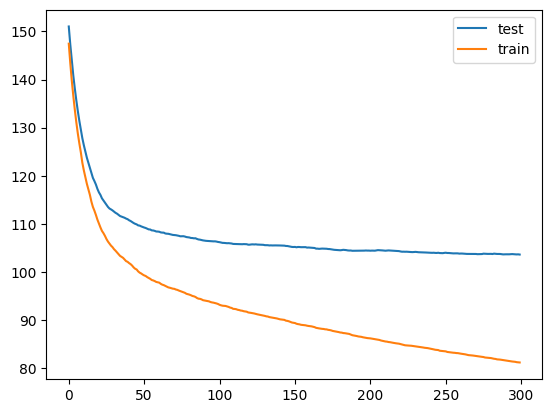

In [30]:
plt.plot(
    search.best_estimator_.evals_result()["validation_0"]["rmse"], label="test")
plt.plot(search.best_estimator_.evals_result()["validation_1"]["rmse"], label="train")
plt.legend()

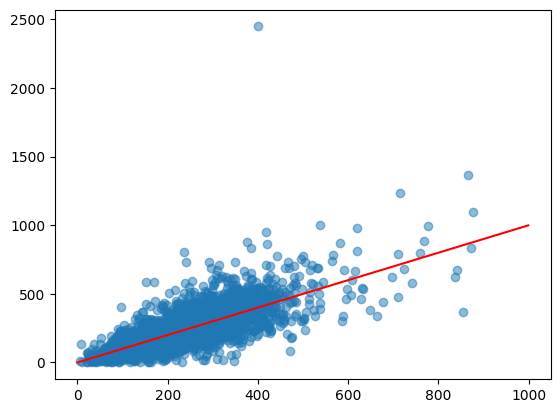

In [31]:
plt.scatter(
    y_pred,
    y_test,
    alpha=0.5
)

plt.plot(np.arange(0, 1000), np.arange(0, 1000), color="red")   

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

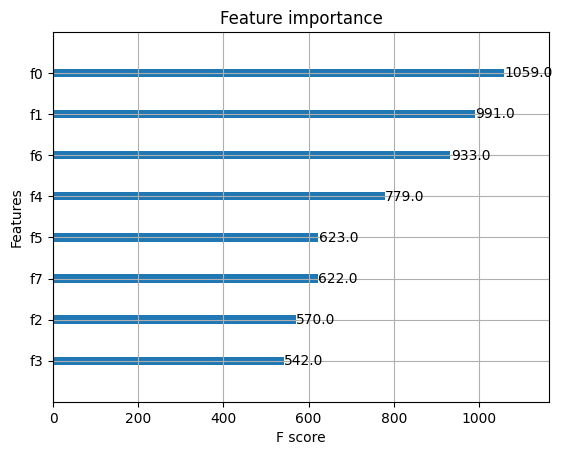

In [32]:
xgb.plot_importance(search.best_estimator_)

In [23]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(max_iter=1000,hidden_layer_sizes=(200,100,50),)

mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))


RMSE:  112.78379464041369


In [24]:
print("RMSE train: ", np.sqrt(mean_squared_error(y_train, model.predict(X_train))))

RMSE train:  104.43752877626618


# Add cluster grouping

In [41]:
final = pd.read_csv("data/final.csv")
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14046 entries, 0 to 14045
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   surface_x                14046 non-null  float64
 1   surface_y                14046 non-null  float64
 2   gross_perforated_length  14046 non-null  float64
 3   number_of_stages         14046 non-null  float64
 4   total_proppant           14046 non-null  float64
 5   total_fluid              14046 non-null  float64
 6   true_vertical_depth      14046 non-null  float64
 7   frac_seasoning           14046 non-null  float64
 8   OilPeakRate              14046 non-null  float64
dtypes: float64(9)
memory usage: 987.7 KB


In [42]:
cluster_labels = pd.read_csv("data/cluster_label_features.csv")
cluster_labels.rename(columns={"Unnamed: 0": "original_index"}, inplace=True)
cluster_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17868 entries, 0 to 17867
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   original_index         17868 non-null  int64  
 1   surface_x              17868 non-null  float64
 2   surface_y              17868 non-null  float64
 3   bh_x                   17868 non-null  float64
 4   bh_y                   17868 non-null  float64
 5   horizontal_midpoint_x  17868 non-null  float64
 6   horizontal_midpoint_y  17868 non-null  float64
 7   horizontal_toe_x       17868 non-null  float64
 8   horizontal_toe_y       17868 non-null  float64
 9   surface_toe_len        17868 non-null  float64
 10  surface_midpoint_len   17868 non-null  float64
 11  surface_bh_len         17868 non-null  float64
 12  toe_midpoint_len       17868 non-null  float64
 13  toe_bh_len             17868 non-null  float64
 14  midpoint_bh_len        17868 non-null  float64
 15  cl

In [43]:
final = final.merge(cluster_labels[["original_index", "cluster", "opr_mean_pct_diff"]], left_index=True, right_on="original_index")
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12971 entries, 0 to 12970
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   surface_x                12971 non-null  float64
 1   surface_y                12971 non-null  float64
 2   gross_perforated_length  12971 non-null  float64
 3   number_of_stages         12971 non-null  float64
 4   total_proppant           12971 non-null  float64
 5   total_fluid              12971 non-null  float64
 6   true_vertical_depth      12971 non-null  float64
 7   frac_seasoning           12971 non-null  float64
 8   OilPeakRate              12971 non-null  float64
 9   original_index           12971 non-null  int64  
 10  cluster                  12971 non-null  int64  
 11  opr_mean_pct_diff        12971 non-null  float64
dtypes: float64(10), int64(2)
memory usage: 1.3 MB


In [50]:
(pd.qcut(final[["cluster", "opr_mean_pct_diff"]].drop_duplicates().opr_mean_pct_diff, q=4, labels=False) +1)

0        2
42       1
53       2
54       3
55       3
66       4
3692     1
4247     3
4300     4
4738     4
4749     1
4847     2
4850     1
5041     2
5044     1
5641     3
6178     4
6434     3
8566     2
12741    4
Name: opr_mean_pct_diff, dtype: int64